### Done


### Missing
* TensorBoard Summaries
* FFNN
* RNN

In [1]:
%%javascript

Jupyter.keyboard_manager.command_shortcuts.add_shortcut('r', {
    help : 'run all cells',
    help_index : 'zz',

    handler : function (event) {
        IPython.notebook.execute_all_cells();
        return false;
    }
});

<IPython.core.display.Javascript object>

In [2]:
%%time
from __future__ import absolute_import, division, print_function, unicode_literals

# standard libraries
import os

# 3rd party libraries
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import gym

# from tensorflow.contrib.keras.python.keras import backend as K

# Custom libraries
import CartPole_config as config
import utils
# import networks
# # import A3C
from Logger import Logger

Wall time: 2.38 s


In [3]:
%%time
import networks

Wall time: 11.1 s


In [4]:
experiment_name = None
# experiment_name = 'gamma09'

load_model = False
wipe_records = not load_model

## Hyperparameters
LEARNING_RATE = 1e-5

# Script behavior
Tmax = 100
tmax = 5
T = 0

# Model



In [5]:
## Derived parameters
experiment_name = experiment_name or utils.time_str()
logdir = './logdir/'+config.env_name+'/A3C/' + experiment_name
print('logdir: ', logdir)


logdir:  ./logdir/CartPole-v1/A3C/2017-07-07-(12-41-15)


In [6]:
%%time

from tensorflow.contrib.keras.api.keras.layers import Dense, Input
from tensorflow.contrib.keras.api.keras.models import Model


Wall time: 0 ns


In [7]:
# %%time

tf.reset_default_graph()

class ActorCritic:
    """ ActorCritic class encapsulates the neural network, TensorFlow 
        graph definition and related computation for an actor-critic model
    """
    __name__ = 'ActorCritic'
    def __init__(self):
        self.sess = tf.Session()

        from tensorflow.contrib.keras.python.keras.backend import set_session, manual_variable_initialization
        set_session(self.sess)
        manual_variable_initialization(True)
        
        self.obsPH = tf.placeholder(tf.float32, shape=[None]+[config.num_state], name='obsPlaceholder')
        self.actionPH = tf.placeholder(tf.int32, shape=[None, 1], name='actionPlaceholder')
        self.discoutedRewardPH = tf.placeholder(tf.float32, shape=[None, 1], name='discoutedRewardPlaceholder')
        
        self.model = self._build_model()
        self.graph = self._build_graph(LEARNING_RATE)
        self.saver = tf.train.Saver(max_to_keep=5)
        self.summary_writer = tf.summary.FileWriter(logdir, self.sess.graph)
        self.logger = Logger(logdir)
        self.logger.writer = self.summary_writer
        
        self.sess.run(tf.global_variables_initializer())
        self.default_graph = tf.get_default_graph()
        self.default_graph.finalize() # no more modification!
    
    def load_model(self, path):
        ckpt = tf.train.get_checkpoint_state(path)
        self.saver.restore(self.sess, ckpt.model_checkpoint_path)
    
    def save_model(self, path):
        self.saver.save(self.sess, path)
    
    def _build_model(self):
        input_layer = Input(tensor=self.obsPH)
        model_layers = networks.build_dense(input_layer, config.layers, name_stem='stem_')
        model = Model(inputs=input_layer, outputs=model_layers)
        return model

    def _build_graph(self, learning_rate):
        class ACGraph: pass; 
        graph = ACGraph

        with tf.variable_scope('critic'):
            graph.value = Dense(1, activation='linear')(self.model.output)
            graph.advantage = self.discoutedRewardPH - graph.value
            graph.loss_value = config.loss_v_coef * tf.reduce_mean(tf.square(graph.advantage))
#             print('graph.value\t', graph.value.get_shape())
#             print('graph.advantage\t', graph.advantage.get_shape())
#             print('graph.loss_value\t', graph.loss_value.get_shape())
#             print()
                
        graph.action_hot = tf.one_hot(self.actionPH, depth=config.num_action)
        graph.action_hot = tf.squeeze(graph.action_hot, axis=1)
            # TODO: this is shit!
        with tf.variable_scope('actor'):
            graph.action_probs = Dense(config.num_action, 
                                   activation='softmax')(self.model.output)
#             graph.action_prob = tf.reduce_sum(graph.action_probs * action_hot, 
#                                     axis=1, keep_dims=True)
            graph.action_pre_sum = tf.multiply(graph.action_probs, graph.action_hot)
            graph.action_prob = tf.reduce_sum(graph.action_pre_sum, 
                                              axis=1,keep_dims=True)
            log_prob = tf.log(graph.action_prob + config.eps) # log probability of selected action (scalar)
            graph.loss_policy = - tf.reduce_mean(log_prob * tf.stop_gradient(graph.advantage))
            graph.loss_entropy = config.loss_entropy_coef * tf.reduce_mean(
                graph.action_probs * tf.log(graph.action_probs + config.eps))
#             print('action_hot\t', graph.action_hot.get_shape())            
#             print('graph.action_probs\t', graph.action_probs.get_shape())            
#             print('graph.action_prob\t', graph.action_prob.get_shape())
#             print('log_prob\t', log_prob.get_shape())
#             print()

#             print('graph.loss_policy\t', graph.loss_policy.get_shape())
#             print('graph.loss_entropy\t', graph.loss_entropy.get_shape())

        graph.loss_total = graph.loss_policy + graph.loss_value + graph.loss_entropy
#         print('graph.loss_total\t', graph.loss_total.get_shape())
#         print()

        optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=0.99)
        
        grads_and_vars = optimizer.compute_gradients(graph.loss_total)
        grads, variables = zip(*grads_and_vars)
#         clipped_gradients = [(tf.clip_by_value(grad, -1., 1.), var)
#                          for grad, var in grads_and_vars]
        clipped_gradients, _ = (tf.clip_by_global_norm(grads, 1.))
        graph.train_op = optimizer.apply_gradients(zip(clipped_gradients, variables))

        for g, v in grads_and_vars:
            if g is not None:
                tf.summary.histogram('grad_org/'+v.name[:-2], g)
                tf.summary.histogram('var/'+v.name[:-2], g)
    #             print(v.name, v.get_shape())
        for g, v in zip(clipped_gradients, variables):
            if g is not None:
                tf.summary.histogram('grad_clip/'+v.name[:-2], g)


#         optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=0.99)
#         graph.train_op = optimizer.minimize(graph.loss_total)

        tf.summary.scalar('training/loss_value', graph.loss_value)
        tf.summary.scalar('training/loss_policy', graph.loss_policy)
        tf.summary.scalar('training/loss_entropy', graph.loss_entropy)
        tf.summary.scalar('training/loss_total', graph.loss_total)

#         tf.summary.scalar('performance/value', graph.value)
#         tf.summary.scalar('performance/discoutedReward', self.discoutedRewardPH)
#         tf.summary.scalar('performance/action_prob', graph.action_prob)
        graph.summary = tf.summary.merge_all()
        return graph

class TrainingMemory:
    __name__ = 'TrainingMemory'
    def __init__(self):
        self.reset()

    def reset(self, keep=None):
        if keep is None:
            self.obs = []
            self.action = []
            self.reward = []
            self.obs_next = []
#             self.obs_mask = []
            self.eps_t = []
        else: # keep the last 'keep' experiences
            num_to_delete = self.size - keep
            self.obs = self.obs[num_to_delete:]
            self.action = self.action[num_to_delete:]
            self.reward = self.reward[num_to_delete:]
            self.obs_next = self.obs_next[num_to_delete:]            
#             self.obs_mask = self.obs_mask[num_to_delete:]
            self.eps_t = self.eps_t[num_to_delete:]
    
    def add(self, obs, action, reward, obs_next, done, eps_t):
        self.obs.append(obs)
        self.action.append(action)
        self.reward.append(reward)
        self.eps_t.append(eps_t)
        if done:
            self.obs_next.append(obs_next)
#             self.obs_next.append(np.zeros_like(obs)) # just a dummy!
#             self.obs_mask.append(0.)
        else:
            self.obs_next.append(obs_next)
#             self.obs_mask.append(1.)
    
    @property
    def size(self):
        return len(self.obs)
    
    def test(self):
        pass
#         print('Testing', self.__name__)
#         memory = TrainingMemory()
#         utils.print_attributes(memory)

#         memory.add(obs=1, action=2, reward=3, obs_next=4, done=False)
#         memory.add(obs=1, action=2, reward=3, obs_next=4, done=False)
#         memory.add(obs=1, action=2, reward=3, obs_next=4, done=False)
#         memory.add(obs=1, action=2, reward=3, obs_next=4, done=False)
#         memory.add(obs=1, action=2, reward=3, obs_next=4, done=True)
#         print('size', memory.size)
#         print(memory.obs)
#         print(memory.action)
#         print(memory.reward)
#         print(memory.obs_next)
#         print(memory.obs_mask)

#         memory.reset(keep=2)
#         print('size', memory.size)
#         print(memory.obs)
#         print(memory.action)
#         print(memory.reward)
#         print(memory.obs_next)
#         print(memory.obs_mask)

# TrainingMemory.test(TrainingMemory)

In [8]:
import threading
n_max = 3 # largest n in n-step rewards
NUM_FRAMES = 0 # should probably be added to the brain
EPS_NUM = 0
max_train_frames = 200000
max_train_frames = np.inf

# EPS_START = 1
# EPS_STOP = 0.0
# EPS_STEPS = 50000

In [9]:
batch_size = 4


class A3C_agent(threading.Thread):
    """ Holds a copy of the environment and trains on it asynchroneously"""
    stop_signal = False
    
    
    def __init__(self, brain, number, render=False, train=True):
        threading.Thread.__init__(self)
        self.env = gym.make(config.env_name)
        self.memory = TrainingMemory()
        
        self.number = number
        self.name = 'A3Cworker_' + str(self.number)
        self.brain = brain
        self.render = render
        self.train = train
        
        
    def get_action(self, obs):
        """ Takes a single obs, and returns a single action"""
        obs = [obs]
        [p] = self.brain.sess.run(
                self.brain.graph.action_probs,
                feed_dict={self.brain.obsPH : obs})
        a = np.random.choice(config.num_action, p=p)
        return a
    
#     def get_train_batch(self, n):
#         assert self.memory.size > 0, 'Error: self.memory.size = ' + str(self.memory.size)
#         s = np.vstack(self.memory.obs)
#         a = np.vstack(self.memory.action)
#         r = np.vstack(self.memory.reward)
#         t = np.vstack(self.memory.eps_t)

# #         print('s', s.shape)
# #         print('a', a.shape)
# #         print('r', r.shape)
        
#         if n is not None:
#             s_ = np.vstack(self.memory.obs_next)
#             return s[:-n], a[:-n], r, s_, t
#                 # r and s_ are longther than the others!
#         return s, a, r, None, t

#     def discount_r_not_terminal(self, r, n):
#         assert len(r) == len(s_), \
#             'Error: len(r)='+str(len(r))+' != '+str(len(s_))+'len(s_), '
#         r_dis = np.zeros_like(r[:-n])
#         v = self.brain.sess.run(
#             self.brain.graph.value,
#             feed_dict={self.brain.obsPH : s_})
#         for i in reversed(range(len(r_dis))):
#             for j in range(n-1):
#                 r_dis[i] += config.gamma**j * r[i+j]
#             r_dis[i] += config.gamma**(n-1) * v[i+n-1]
#                 # v is computed from s_ which is already t+1
#         return r_dis

    def discount_r_terminal(self, r):
        """ Compute the true total discounted reward, no estimation"""
        r_dis = np.zeros_like(r)
        
        for i in reversed(range(len(r))):
            if i == len(r)-1:
                r_dis[i] = r[i]
            else:
                r_dis[i] = r[i] + config.gamma*r_dis[i+1]

#         print('discount_r_terminal')
#         print('r_dis', r_dis.shape)
#         print(r_dis)
#         print()
#         print('v', v.shape)
#         print(v)
        return r_dis

    def discount_r_n_step(self, r, s_next, n_max):
        """ r_dis(t) = """
        
        r_dis = np.zeros_like(r[:batch_size])
        v = self.brain.sess.run(
            self.brain.graph.value,
            feed_dict={self.brain.obsPH : s_next})

        for i in range(len(r_dis)):
            for n in range(n_max):
                r_dis[i] += config.gamma**n * r[i]
            r_dis[i] += config.gamma**n_max * v[i + n_max - 1]
                # v is computed from s_next which is already t+1

#         print('discount_r_n_step')
#         print('r_dis', r_dis.shape)
#         print(r_dis)
#         print()
#         print('v', v.shape)
#         print(v)
        return r_dis
    
    def get_train_batch(self, terminal, n_max):
        assert self.memory.size > 0, 'Error: self.memory.size = ' + str(self.memory.size)
        s = np.vstack(self.memory.obs)
        a = np.vstack(self.memory.action)
        r = np.vstack(self.memory.reward)

        if terminal:
            r_dis = self.discount_r_terminal(r)
            assert len(r_dis) == self.memory.size, 'Error: len(r_dis)=' + str(len_r_dis) + ', self.memory.size=' + str(self.memory.size)
            return s, a, r_dis
        else:
            # Full n-step implementation
            s_next = np.vstack(self.memory.obs_next)
            r_dis = self.discount_r_n_step(r, s_next, n_max)

            # TODO: implement the multi-step returns
            assert len(r_dis) == batch_size, \
                "Error, len(r_dis) should be batch_size, "+str(batch_size) \
                + ", but it is"+len(r_dis)
            return s[:batch_size], a[:batch_size], r_dis
    
        # return length should 

    
    def update_weights(self, n_max, terminal):
        """ self.memory may only contain consecutive experience from within
            the same episode
        """
        s, a, r_dis = self.get_train_batch(terminal, n_max)                    

        
#         print('s', s.shape)
#         print('a', a.shape)
#         print('r_dis', r_dis.shape)
#         print(r_dis)
#         print()
#         v = self.brain.sess.run(
#             self.brain.graph.value,
#             feed_dict={self.brain.obsPH : s})
#         print('v', v.shape)
#         print(v)


        _, summary = self.brain.sess.run(
            [self.brain.graph.train_op, self.brain.graph.summary], 
            feed_dict={self.brain.obsPH : s, 
                       self.brain.actionPH : a,
                       self.brain.discoutedRewardPH: r_dis})
        return summary
            
    def stop(self):
        self.stop_signal = True

    def run(self):
        obs = self.env.reset()
        eps_frames = 0
        eps_reward = 0
        eps_reward_sum = []
        eps_num = 0
        global NUM_FRAMES, EPS_NUM
        while self.stop_signal == False:
            try:
                eps_frames += 1
                ## Get experience
                action = self.get_action(obs)
                obs_new, reward, done, _ = self.env.step(action)
                if self.render: self.env.render()

                ## Save experience
                reward = np.clip(reward, -1, 1)
                eps_reward += reward
                self.memory.add(obs=obs, action=action, reward=reward, 
                                obs_next=obs_new, done=done, eps_t=eps_frames)
                obs = obs_new

                # [TRAIN]
                if done:
                    NUM_FRAMES += self.memory.size
                    num_frames = NUM_FRAMES
#                     print('done, {:4}, {:4}, {}'.format(EPS_NUM, eps_frames, num_frames))
                    summary = self.update_weights(n_max, terminal=done)
                    self.memory.reset()
                    self.brain.logger.log_scalar(tag='performance/eps_reward', value=eps_reward, step=num_frames)
                    
                    obs = self.env.reset()
                    eps_frames = 0
                    eps_reward_sum += [eps_reward]
                    eps_reward = 0
                    save_interval = 200
                    EPS_NUM += 1
                    if EPS_NUM % save_interval == 0 and EPS_NUM > 0:
                        print(self.name+': {:5}, {:7.2f}, {:8}, model saved'.format(
                                EPS_NUM, np.mean(eps_reward_sum), num_frames))
                        self.brain.save_model(logdir + '/model_'+str(EPS_NUM))
                        self.brain.logger.log_histogram(tag='train/eps_rewards', 
                                     values=np.array(eps_reward_sum),
                                     step=num_frames)
                        eps_reward_sum = []
#                         break
                    self.brain.summary_writer.add_summary(summary, num_frames)
#                     break


                if self.memory.size >= batch_size + n_max: # We only train where we can get full n_max step returns
                    NUM_FRAMES += batch_size
                    num_frames = NUM_FRAMES
#                     print('memory full', eps_frames, num_frames)
                    summary = self.update_weights(n_max, terminal=done)
                    self.memory.reset(keep=n_max)
                    self.brain.summary_writer.add_summary(summary, num_frames)
#                     break

                if NUM_FRAMES >= max_train_frames:
                    print('NUM_FRAMES >= max_train_frames')
                    self.stop_signal = True
            except KeyboardInterrupt:
                print('KeyboardInterrupt')
                self.stop_signal = True
        print('Training stopped')

print('complete')

complete


In [10]:
## Create a shared brain
print('logdir', logdir)
tf.reset_default_graph()
shared_brain = ActorCritic()
try:
    shared_brain.load_model(logdir)
except AttributeError:
    print("Couldn't find a model to load")

agent = A3C_agent(shared_brain, number=0, render=False)
agent.stop_signal=False


logdir ./logdir/CartPole-v1/A3C/2017-07-07-(12-41-15)
Couldn't find a model to load


In [11]:
## Start agents in the background
num_agents = 3
agents = [A3C_agent(shared_brain, number=i+1, render=False) for i in range(num_agents)]
for a in agents:
    a.start()


[2017-07-07 12:41:19,500] Making new env: CartPole-v1
[2017-07-07 12:41:19,510] Making new env: CartPole-v1
[2017-07-07 12:41:19,515] Making new env: CartPole-v1


In [12]:
## Start agent in the foreground
agent.run()
agent.env.render(close=True)


In [13]:
# # import time
# # time.sleep(10)
# agent.env.render(close=True)

# for a in agents:
#     a.stop()
# for a in agents:
#     a.join()

# print('Terminated')

In [17]:

def idea_value(rewards, gamma):
    perfect_v = [rewards[-1]]
    for i in range(1, len(rewards)):
        perfect_v.append(perfect_v[i-1]*gamma + 1)

    perfect_v = perfect_v[::-1]
    return perfect_v


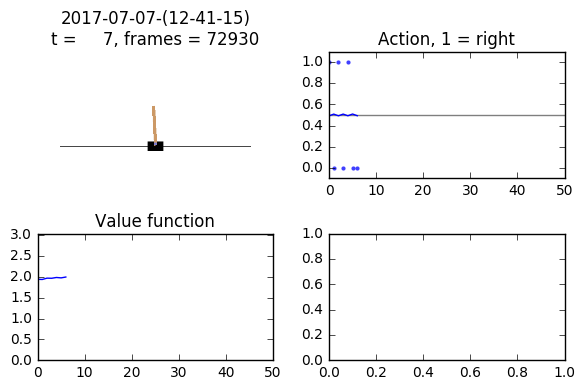

In [ ]:
## Slow episode run
from IPython.display import clear_output

# setup
obs = agent.env.reset()
done = False
reward_sum = 0
action_prob = [] # probability of goint left
action_chosen = []
values = []
v_max = 0
t_max = 50
try:
    while True:    
        
        [p], [v] = agent.brain.sess.run(
                [agent.brain.graph.action_probs, agent.brain.graph.value],
                feed_dict={agent.brain.obsPH : [obs]})
        action_prob.append(p[1])
        values.append(v)
        v_max = 1.25*v if v > v_max else v_max
        a = np.random.choice(config.num_action, p=p)
        action_chosen.append(a)
        obs, reward, done, _ = agent.env.step(a)
        reward_sum += int(reward)
        img = agent.env.render(mode='rgb_array')

        
        if t_max - reward_sum < 10:
            t_max += 50
        fig, ax = plt.subplots(2,2)
        ax[0][0].imshow(img)
        ax[0][0].axis('off')
        ax[0,0].set_title(experiment_name + '\nt = {:5d}, frames = {}'.format(reward_sum, NUM_FRAMES))

        ax[0,1].plot([0, t_max],[0.5, 0.5],'k',alpha=0.5)
        ax[0,1].plot(action_prob)
        ax[0,1].plot(action_chosen, 'bo', markeredgewidth=0.0, markersize=3,alpha=0.75)

        ax[0,1].set_xlim([0,t_max])
        ax[0,1].set_ylim([-0.1, 1.1])
        ax[0,1].set_title('Action, 1 = right')

        
        ax[1,0].plot(values, c='b')
        ax[1,0].set_ylim([0, 1.25 * v_max])
        ax[1,0].set_xlim([0,t_max])
        ax[1,0].set_title("Value function")

        plt.tight_layout()
        clear_output(wait=True)
        
        if done:
            ax[1,1].plot(idea_value(np.ones(reward_sum), config.gamma))
            ax[1,1].set_title('Ideal value function')
            ax[1,1].set_xlim([0, t_max])
            plt.savefig('tmp/training_graphs' + utils.time_str() + '.png', bbox_inches='tight')
            obs = agent.env.reset()
            done = False
            reward_sum = 0
            action_prob = [] # probability of goint left
            action_chosen = []
            values = []
            v_max = 0
            t_max = 50
            
        plt.show()


except KeyboardInterrupt:
    print('KeyboardInterrupt')


print('Terminated', reward_sum)

In [ ]:
# ## Discounted rewards experiments

# rr = [1,1,1,1,1,1,1,1,1,1]
# d1 = []
# d2 = []
# R1 = []
# R2 = []
# for i in range(len(rr)):
# #     print(i)
#     if i == 0: 
#         d1.append(rr[i])
#         d2.append(rr[i])
#     elif i == 1:
#         d1.append(rr[i] + 0.99*d1[i-1]) # standard
#         d2.append(rr[i] + 0.99*d2[i-1])
#     else:
#         d1.append(rr[i] + 0.99*d1[i-1]) # standard
#         d2.append(rr[i] + 0.99*d2[i-1])
    
    
# rr = reversed(rr)
# d1 = reversed(d1)


# def print_list(string, vals):
#     print(string, end=': ')
#     for v in vals:
#         print('{:5.2f}'.format(v), end=', ')
#     print()

# print_list('rr', rr)
# print_list('d1', d1)
